# Exam Project: The formation of ISIS' Social Media Network

Group members: Zeyu Zhao, Helge Zille, Edith Zink, Sina Smid

# Descriptive Analysis

In [2]:
import os
import requests
import re
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('tweets_1.csv')

Unique tweets: 17410
All tweets: 17410


[Text(0, 0, 'Actual Tweets'), Text(0, 0, 'Retweets')]

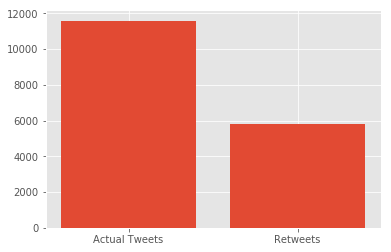

In [4]:
# How many of the tweets are actually re-tweets?
print("Unique tweets: {}".format(len(data['tweets'].unique())))
print("All tweets: {}".format(len(data['tweets'])))

retweets = []
actual_tweets = []
for user, tweet in zip(data['username'], data['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        actual_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

actual_tweets = np.array(actual_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(actual_tweets[:,1]), len(retweets[:,1])], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Actual Tweets', 'Retweets'])

Text(0.5, 1.0, 'Mentioned vs. Total in tweets.csv')

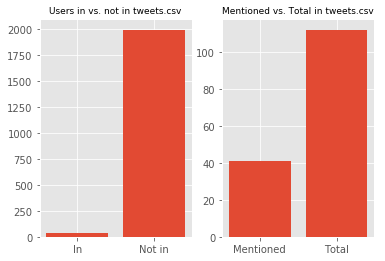

In [5]:
# How many users have been mentioned by other users?
in_set = []
not_in_set = []
for record in actual_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in data['username'].unique()) and (record[0] != name[1:]):
                in_set.append([record[0], name[1:]])
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]])

in_set = np.array(in_set)
not_in_set = np.array(not_in_set)

fig, ax = plt.subplots(1,2)

ax[0].bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center')
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['In', 'Not in'])
ax[0].set_title('Users in vs. not in tweets.csv', fontsize=9)

ax[1].bar([1,2], [len(np.unique(in_set[:,1])), len(data['username'].unique())], align='center')
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['Mentioned', 'Total'])
ax[1].set_title('Mentioned vs. Total in tweets.csv', fontsize=9)


# majority of users mentioned are outside the scope of the dataset.
# ca. 40 out of 110 users are mentioned within the dataset.
# only use mentioned usernames where users are not mentioning themselves.

In [6]:
# Map the most influential/ most mentioned users
sender_count = Counter(in_set[:,0])
receiver_count = Counter(in_set[:,1])
top_5_senders = sender_count.most_common(5)
top_5_receivers = receiver_count.most_common(5)

print(top_5_senders)
print(top_5_receivers)

# Manybe for the senders we could include self-mentioning?

# And who are these top 5?
for name, _ in top_5_receivers:
    print("Username: {} - {}\n".format(name,
            data[data['username'] == name]['description'].dropna().unique()[0]))

[('MaghrabiArabi', 49), ('WarReporter1', 30), ('AsimAbuMerjem', 27), ('Uncle_SamCoco', 27), ('moustiklash', 20)]
[('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]
Username: RamiAlLolah - Real-Time News, Exclusives, Intelligence & Classified Information/Reports from the ME. Forecasted many Israeli strikes in Syria/Lebanon. Graphic content.

Username: Nidalgazaui - 17yr. old Freedom Activist
/Correspondence of NGNA /Terror Expert/Middle East Expert. Daily News about Syria/Iraq/Yemen/Russia/Middle East

Username: MilkSheikh2 - Muslim, Iraqi, Banu Zubid, Qahtani, Chef, Engineer, Remaining until the best of them, fights al-Dajjal, Translate Old stuff mostly

Username: WarReporter1 - Reporting on conflicts in the MENA and Asia regions.

Username: _IshfaqAhmad - Medico at GMC Srinagar • Pro-Khilafah • Anti-Democratic • Anti-Nationalistic • Anti-Rafidah • Innocent Bystander of the Conflict in Middle East • Cricketist •



In [11]:
# Network based on metioning each other:
graph = nx.Graph()

all_users = list(set(in_set[:,0]) | set(in_set[:,1]))
graph.add_nodes_from(all_users, count=10)
node_colours = []

# Generate 3 categories of nodes: only senders, only receivers, senders and receivers
for node in graph.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours.append('g')
    elif node in np.unique(in_set[:,0]):
        node_colours.append('r')
    elif node in np.unique(in_set[:,1]):
        node_colours.append('b')

# Build weighted edges between users in the graph
edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count
        
for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)
    
followers = {}
tweet_num = {}
for username in all_users:
    followers[username] = data[data['username'] == username]['followers'].unique()[-1]
    tweet_num[username] = data[data['username'] == username]['tweets'].count()

sizes = [(followers[n] / tweet_num[n]) * 50 for n in graph.nodes()]
weights = [graph[u][v]['weight']/2 for u, v in graph.edges()]


plt.figure(figsize=(12,12))
nx.draw(graph, pos=nx.spring_layout(graph, k=0.15,scale=2,iteration=20), node_color=node_colours, node_size=sizes, with_labels=True, width=weights)
plt.show()

TypeError: fruchterman_reingold_layout() got an unexpected keyword argument 'iteration'

<Figure size 864x864 with 0 Axes>